<a href="https://colab.research.google.com/github/johnberg1/COMP447-547-S22/blob/main/demos/demo1/Autoregressive_PS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP447/547 PS on Autoregressive Models
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [1]:
!if [ -d demo1-helpers ]; then rm -Rf demo1-helpers; fi
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uzCDGGBNmAH_LixG5UG7g-9SnzYdIn3w' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uzCDGGBNmAH_LixG5UG7g-9SnzYdIn3w" -O demo1-helpers && rm -rf /tmp/cookies.txt
!gdown --id 1cFivKZ4VGwp8euOjVlQEV609FyVXU0pC
!unzip -qq demo1-helpers.zip
!rm demo1-helpers.zip
!pip install demo1-helpers/

Downloading...
From: https://drive.google.com/uc?id=1cFivKZ4VGwp8euOjVlQEV609FyVXU0pC
To: /content/demo1-helpers.zip
100% 13.9k/13.9k [00:00<00:00, 20.5MB/s]
Processing ./demo1-helpers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deepul-helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=8826 sha256=ba3ea18bda8d0a94c20871c7f4d823d858f04e19ac58522a5e6512e237cfe909
  Stored in directory: /root/.cache/pip/wheels/b3/b4/89/edd5e021dd83961932b007ed39e816d876fac059a0146571ab
Successfully built deepul-helper


In [2]:
!if [ -d pretrained_models ]; then rm -Rf pretrained_models; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VURR9HFjO5iYPUfHFoCTfuRLqMW5gYr5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VURR9HFjO5iYPUfHFoCTfuRLqMW5gYr5" -O pretrained_models.zip && rm -rf /tmp/cookies.txt
!unzip -qq pretrained_models.zip
!rm pretrained_models.zip

--2022-03-03 13:19:26--  https://docs.google.com/uc?export=download&confirm=t&id=1VURR9HFjO5iYPUfHFoCTfuRLqMW5gYr5
Resolving docs.google.com (docs.google.com)... 142.250.157.139, 142.250.157.100, 142.250.157.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.157.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/paged70gn6vnp5aqjs51e1s5n5l99ihj/1646313525000/06419056966375271799/*/1VURR9HFjO5iYPUfHFoCTfuRLqMW5gYr5?e=download [following]
--2022-03-03 13:19:26--  https://doc-0s-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/paged70gn6vnp5aqjs51e1s5n5l99ihj/1646313525000/06419056966375271799/*/1VURR9HFjO5iYPUfHFoCTfuRLqMW5gYr5?e=download
Resolving doc-0s-48-docs.googleusercontent.com (doc-0s-48-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0s-48-docs.googleusercontent.com (doc-0

In [3]:
def load_data():
    from torchvision import transforms
    from torchvision.datasets import MNIST
    import torch.utils.data as data

    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: (x > 0.5).float()
    ])
    train_dset = MNIST('data', transform=transform, train=True, download=True)
    test_dset = MNIST('data', transform=transform, train=False, download=True)

    train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True,
                                   pin_memory=True, num_workers=2)
    test_loader = data.DataLoader(test_dset, batch_size=128, shuffle=True,
                                  pin_memory=True, num_workers=2)

    return train_loader, test_loader
load_data()
print('Pre-downloaded dataset')

import warnings
warnings.filterwarnings('ignore')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Pre-downloaded dataset


# A Simple Autoregressive Model on 2D Data

In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deepul_helper.data import load_demo_2
from deepul_helper.utils import to_one_hot
from deepul_helper.visualize import plot_2d_dist, plot_train_curves

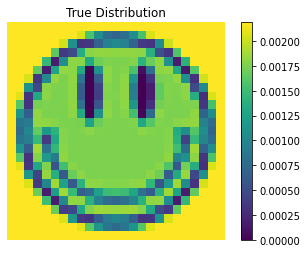

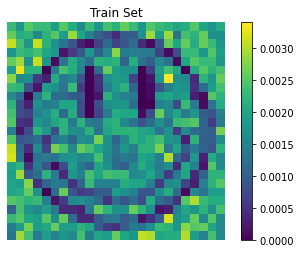

In [5]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda')
n_train, n_test, d = 10000, 2500, 25
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_demo_2(n_train, n_test, d, loader_args, visualize=True)

In [6]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return np.mean(train_losses[-50:])

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer)
        test_loss = eval_loss(model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if epoch in [0, 2, 19, 49]:
            plot_2d_dist(model.get_dist(), title=f'Epoch {epoch}, Learned Distribution')

    plot_2d_dist(model.get_dist())
    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

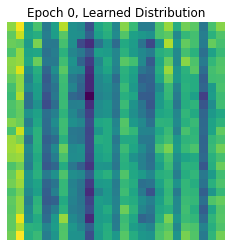

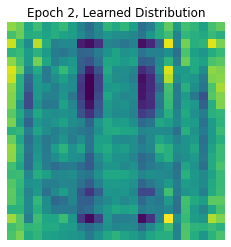

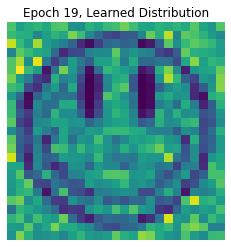

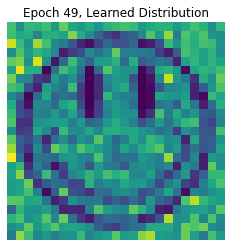

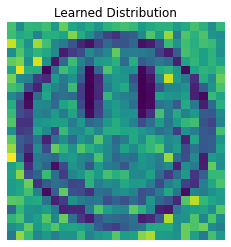

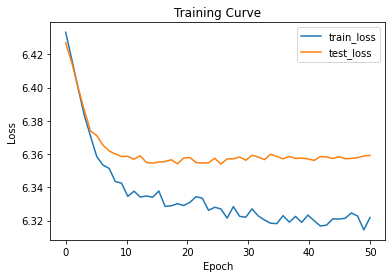

In [7]:
class SimpleAutoregModel(nn.Module):
    # Model p(x0)p(x1|x0), p(x0) as a histogram, p(x1|x0) as an MLP
    def __init__(self):
        super().__init__()
        self.logits_x0 = nn.Parameter(torch.zeros(d), requires_grad=True)
        self.cond_x1 = nn.Sequential(
            nn.Linear(d, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, d)
        )

    def nll(self, x):
        batch_size = x.shape[0]
        x0, x1 = x[:, 0], x[:, 1],

        # Loss for x0
        logits_x0 = self.logits_x0.unsqueeze(0).repeat(batch_size, 1)
        nll_x0 = F.cross_entropy(logits_x0, x0.long())

        # Loss for x1 | x0
        x0_onehot = to_one_hot(x0.long(), d, device) # use onehot as input
        logits_x1 = self.cond_x1(x0_onehot)
        nll_x1 = F.cross_entropy(logits_x1, x1.long())

        return nll_x0 + nll_x1

    def get_dist(self):
        with torch.no_grad():
            x0 = torch.arange(d).to(device)
            x0 = to_one_hot(x0, d, device)

            prob_x0 = F.softmax(self.logits_x0, dim=0).unsqueeze(1)
            prob_x1 = F.softmax(self.cond_x1(x0), dim=1)
            prob = prob_x0 * prob_x1
            return prob.cpu().numpy()


model = SimpleAutoregModel().to(device)
train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3))

# Different Autoregressive Model Architectures

In [8]:
import numpy as np
import torch
import torch.nn as nn
from os.path import join
from deepul_helper.models import RNN, MADE, WaveNet
from deepul_helper.visualize import visualize_batch

device = torch.device('cuda')
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## RNN

In [9]:
def append_location(x, device):
    idxs = torch.arange(28).float() / 27  # Scale to [0, 1]
    locs = torch.stack(torch.meshgrid(idxs, idxs), dim=-1)
    locs = locs.permute(2, 0, 1).contiguous().unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
    locs = locs.to(device)

    x = torch.cat((x, locs), dim=1)
    return x

In [10]:
class RNN_Example(nn.Module):

    def __init__(self, device, append_loc=False, input_shape=(1, 28, 28), hidden_size=256):
        super().__init__()
        self.device = device
        self.append_loc = append_loc
        self.input_channels = input_shape[0] + 2 if append_loc else input_shape[0]
        self.hidden_size = hidden_size
        self.input_shape = input_shape
        self.canvas_size = input_shape[1] * input_shape[2]

        self.lstm = nn.LSTM(self.input_channels, self.hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, input_shape[0])

    def nll(self, x):
        batch_size = x.shape[0]
        x_inp = append_location(x, self.device) if self.append_loc else x

        # Shift input by one to the right
        x_inp = x_inp.permute(0, 2, 3, 1).contiguous().view(batch_size, self.canvas_size, self.input_channels)
        x_inp = torch.cat((torch.zeros(batch_size, 1, self.input_channels).to(self.device), x_inp[:, :-1]), dim=1)

        h0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x_inp, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out).squeeze(-1) # b x 784

        return F.binary_cross_entropy_with_logits(out, x.view(batch_size, -1))


    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, 1, self.input_channels).to(self.device)
            h = torch.zeros(1, n, self.hidden_size).to(self.device)
            c = torch.zeros(1, n, self.hidden_size).to(self.device)

            for i in range(self.canvas_size):
                x_inp = samples[:, [i]]
                out, (h, c) = self.lstm(x_inp, (h, c))
                out = self.fc(out[:, 0, :])
                prob = torch.sigmoid(out)
                sample_pixel = torch.bernoulli(prob).unsqueeze(-1) # n x 1 x 1
                if self.append_loc:
                    loc = np.array([i // 28, i % 28]) / 27
                    loc = torch.FloatTensor(loc).to(self.device)
                    loc = loc.view(1, 1, 2).repeat(n, 1, 1)
                    sample_pixel = torch.cat((sample_pixel, loc), dim=-1)
                samples = torch.cat((samples, sample_pixel), dim=1)

            if self.append_loc:
                samples = samples[:, 1:, 0] # only get sampled pixels, ignore location
            else:
                samples = samples[:, 1:].squeeze(-1) # n x 784
            samples = samples.view(n, *self.input_shape)
            return samples.cpu()


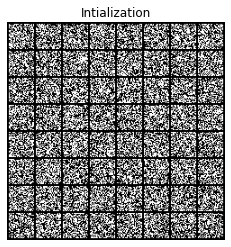

Epoch 0 Test Loss: 0.2357 bits/dim


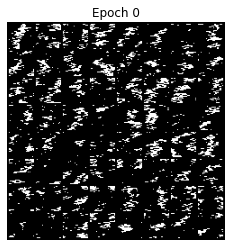

Epoch 1 Test Loss: 0.1543 bits/dim


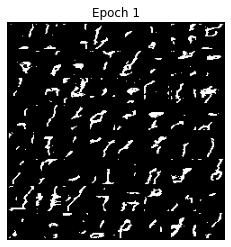

Epoch 2 Test Loss: 0.1417 bits/dim


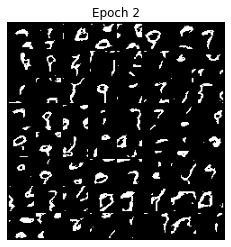

Epoch 8 Test Loss: 0.1234 bits/dim


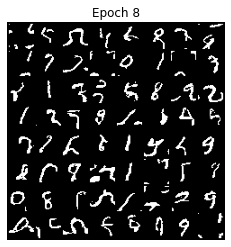

Epoch 19 Test Loss: 0.1113 bits/dim


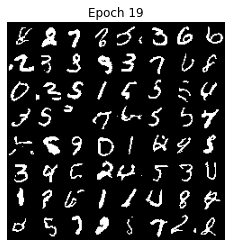

In [11]:
model = RNN(device, append_loc=False).to(device)
test_losses = np.load(join('pretrained_models', 'rnn', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'rnn', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## RNN with Pixel Location Appended as Features

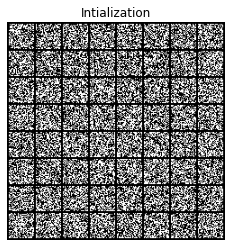

Epoch 0 Test Loss: 0.1794 bits/dim


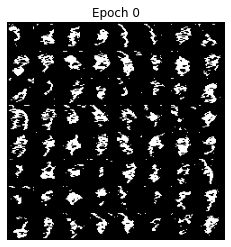

Epoch 1 Test Loss: 0.1448 bits/dim


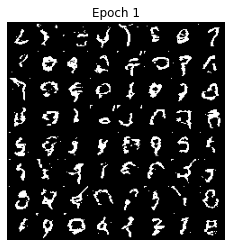

Epoch 2 Test Loss: 0.1333 bits/dim


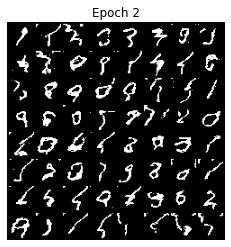

Epoch 8 Test Loss: 0.1187 bits/dim


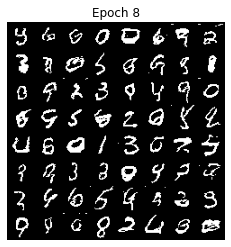

Epoch 19 Test Loss: 0.1117 bits/dim


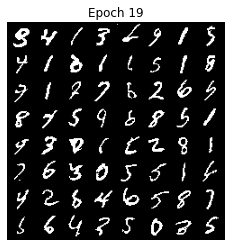

In [12]:
model = RNN(device, append_loc=True).to(device)
test_losses = np.load(join('pretrained_models', 'rnn_loc', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'rnn_loc', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## MADE

In [13]:
# Code based one Andrej Karpathy's implementation: https://github.com/karpathy/pytorch-made
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, device, input_shape=(1, 28, 28), hidden_size=[512, 512, 512], ordering=np.arange(784)): # 0,1,2...,784
        super().__init__()
        self.nin = input_shape[1] * input_shape[2]
        self.nout = input_shape[1] * input_shape[2]
        self.hidden_sizes = hidden_size
        self.ordering = ordering
        self.device = device
        self.input_shape = input_shape

        # define a simple MLP neural net
        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)

        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes)

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), self.nin - 1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def nll(self, x):
        x = x.view(-1, self.nin) # Flatten image
        logits = self.net(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, self.nin).to(self.device)
        self.inv_ordering = {x: i for i, x in enumerate(self.ordering)}
        with torch.no_grad():
            for i in range(self.nin):
                logits = self.net(samples)[:, self.inv_ordering[i]]
                probs = torch.sigmoid(logits)
                samples[:, self.inv_ordering[i]] = torch.bernoulli(probs)
            samples = samples.view(n, *self.input_shape)
        return samples.cpu()

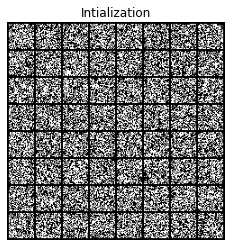

Epoch 0 Test Loss: 0.3172 bits/dim


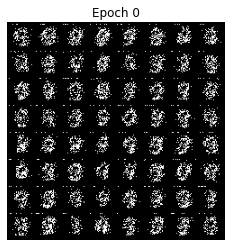

Epoch 1 Test Loss: 0.2725 bits/dim


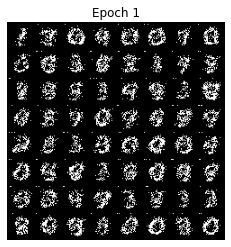

Epoch 2 Test Loss: 0.2454 bits/dim


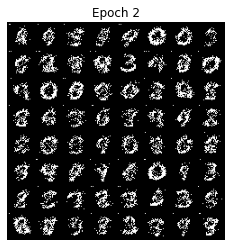

Epoch 8 Test Loss: 0.1915 bits/dim


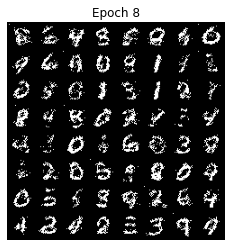

Epoch 19 Test Loss: 0.1731 bits/dim


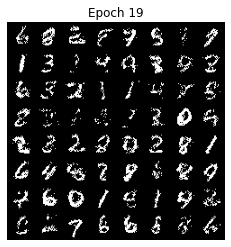

In [14]:
model = MADE(device).to(device)
test_losses = np.load(join('pretrained_models', 'made_0', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'made_0', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## WaveNet

In [15]:
# Implementation pulled from https://github.com/ryujaehun/wavenet
# Type 'B' Conv
class DilatedCausalConv1d(nn.Module):
    """Dilated Causal Convolution for WaveNet"""
    def __init__(self, mask_type, in_channels, out_channels, dilation=1):
        super(DilatedCausalConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size=2, dilation=dilation, padding=0)
        self.dilation = dilation
        self.mask_type = mask_type
        assert mask_type in ['A', 'B']

    def forward(self, x):
        if self.mask_type == 'A':
            return self.conv(F.pad(x, [2, 0]))[:, :, :-1]
        else:
            return self.conv(F.pad(x, [self.dilation, 0]))


class ResidualBlock(nn.Module):
    def __init__(self, res_channels, dilation):
        super(ResidualBlock, self).__init__()

        self.dilated = DilatedCausalConv1d('B', res_channels, 2 * res_channels, dilation=dilation)
        self.conv_res = nn.Conv1d(res_channels, res_channels, 1)

    def forward(self, x):
        output = self.dilated(x)

        # PixelCNN gate
        o1, o2 = output.chunk(2, dim=1)
        output = torch.tanh(o1) * torch.sigmoid(o2)
        output = x + self.conv_res(output) # Residual network

        return output


class WaveNet_Example(nn.Module):
    def __init__(self, device):
        super(WaveNet, self).__init__()

        in_channels = 3
        out_channels = 1
        res_channels = 64
        layer_size = 9 # Largest dilation is 512
        stack_size = 1

        self.causal = DilatedCausalConv1d('A', in_channels, res_channels, dilation=1)
        self.res_stack = nn.Sequential(*[ResidualBlock(res_channels, 2 ** i)
                                         for i in range(layer_size)])
        self.out_conv = nn.Conv1d(res_channels, out_channels, 1)
        self.device = device

    def forward(self, x):
        batch_size = x.shape[0]
        x = append_location(x, self.device)
        output = x.view(batch_size, -1, 784)
        output = self.causal(output)
        output = self.res_stack(output)
        output = self.out_conv(output)
        return output.view(batch_size, 1, 28, 28)

    def nll(self, x):
        logits = self(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, 1, 28, 28).to(self.device)
            for r in range(28):
                for c in range(28):
                    logits = self(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

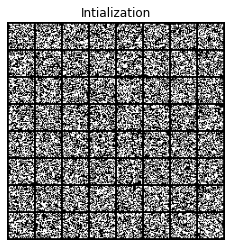

Epoch 0 Test Loss: 0.1453 bits/dim


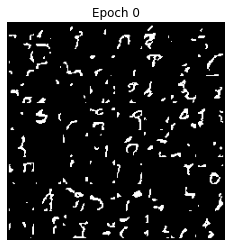

Epoch 1 Test Loss: 0.1398 bits/dim


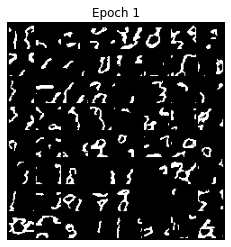

Epoch 2 Test Loss: 0.1379 bits/dim


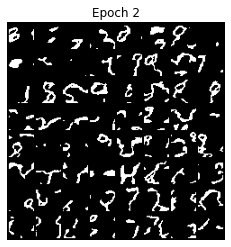

Epoch 8 Test Loss: 0.1349 bits/dim


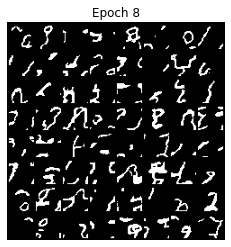

Epoch 19 Test Loss: 0.1333 bits/dim


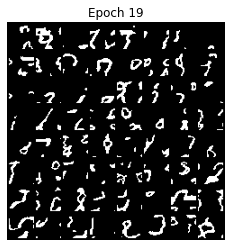

In [16]:
model = WaveNet(device, append_loc=False).to(device)
test_losses = np.load(join('pretrained_models', 'wavenet', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'wavenet', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## WaveNet with Pixel Location Appended as Features

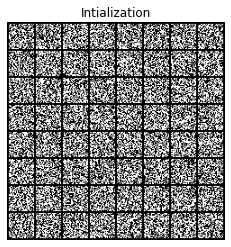

Epoch 0 Test Loss: 0.1340 bits/dim


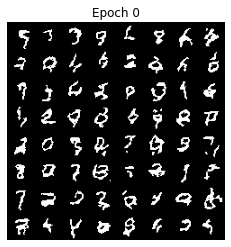

Epoch 1 Test Loss: 0.1279 bits/dim


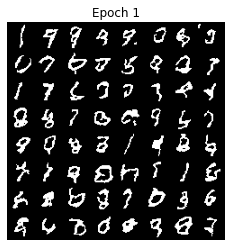

Epoch 2 Test Loss: 0.1259 bits/dim


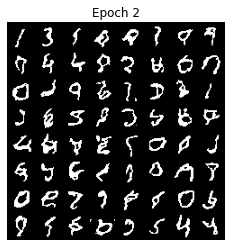

Epoch 8 Test Loss: 0.1219 bits/dim


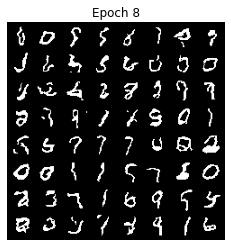

Epoch 19 Test Loss: 0.1193 bits/dim


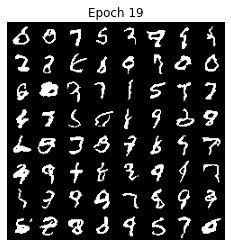

In [17]:
model = WaveNet(device, append_loc=True).to(device)
test_losses = np.load(join('pretrained_models', 'wavenet_loc', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'wavenet_loc', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

# Different Autoregressive Orderings on MADE

Here, we experiment with different autoregressive ordering with MADE on MNIST

In [18]:
from os.path import join
import numpy as np
import torch

from deepul_helper.models import MADE
from deepul_helper.visualize import visualize_batch

device = torch.device('cuda')

In [19]:
def run_demo(ordering, order_id):
    model = MADE(device, ordering=ordering).to(device)
    model.load_state_dict(torch.load(join('pretrained_models', f'made_{order_id}', 'checkpoints', f'epoch19_state_dict')))
    test_losses = np.load(join('pretrained_models', f'made_{order_id}', 'test_losses.npy'))
    samples = model.sample(64)
    print('Test Loss', test_losses[-1])
    visualize_batch(samples, title=f'Samples')

## Order 1: Random Permutation

Test Loss 0.10405158251523972


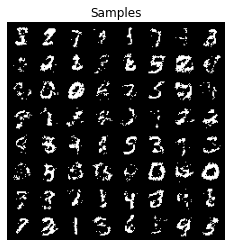

In [20]:
ordering = np.random.RandomState(seed=0).permutation(784)
run_demo(ordering, order_id=1)

## Order 2: Even Indices Then Odd Indices

Test Loss 0.1165621280670166


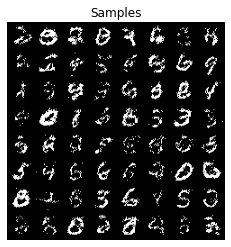

In [21]:
ordering = np.concatenate((np.arange(0, 784, 2), np.arange(1, 784, 2)))
run_demo(ordering, order_id=2)

## Order 3: Rows (Raster Scan)

Test Loss 0.11997873336076736


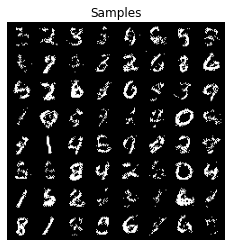

In [22]:
ordering = np.arange(784)
run_demo(ordering, order_id=0)

## Order 4: Columns

Test Loss 0.124317467212677


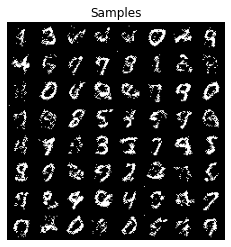

In [23]:
ordering = np.arange(784).reshape(28, 28).T.reshape(-1)
run_demo(ordering, order_id=3)

## Order 4: Top to Middle then Bottom to Middle

Test Loss 0.11842072755098343


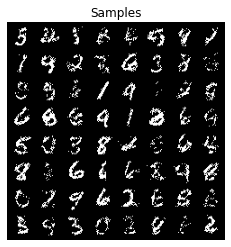

In [24]:
ordering = np.concatenate((np.arange(784 // 2), np.arange(784 // 2, 784)[::-1]))
run_demo(ordering, order_id=4)

*This demo is adapted from UC Berkeley [CS294-158-SP20](https://sites.google.com/view/berkeley-cs294-158-sp20/home)*